# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [4]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
! pip install torch --no-cache-dir
! pip install torchvision

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

In [5]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
from __future__ import print_function, division

import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

# get_ipython().run_line_magic('matplotlib', 'inline')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [5]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -q dogImages.zip


In [6]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"
# bucket = 'img-ngandn18'
data_bucket = 'dec-ngandn18'
bucket = sagemaker_session.default_bucket()

# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
# datapath = 'minidogs'
datapath = 'dogImages'

print(sagemaker_session, bucket, region)


<sagemaker.session.Session object at 0x7fb861be6410> sagemaker-us-east-1-267669939222 us-east-1


In [6]:
# !aws s3 sync ./minidogs s3://${DEFAULT_S3_BUCKET}/minidogs/
inputs = sagemaker_session.upload_data(path=datapath, bucket=data_bucket, key_prefix=datapath)
print(inputs)

s3://dec-ngandn18/dogImages


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.002),
    "batch_size": CategoricalParameter([32, 64, 128])
}

In [13]:
#TODO: Create estimators for your HPs
# estimator = # TODO: Your estimator here
# tuner = # TODO: Your HP tuner here
# Creating estimators for Hyperparameter tuning jobs
#"ml.g4dn.2xlarge" $0.94
# ml.g4dn.4xlarge $1.505

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py38',
    framework_version="1.9",
    instance_count=1,
    instance_type='ml.g4dn.4xlarge'
#     instance_type="ml.g4dn.xlarge" 
    )

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)


In [9]:
# S3 paths for the training job
s3_data_dir = "s3://{}/{}/".format(data_bucket, datapath)
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= s3_data_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir
os.environ['SM_MODEL_DIR']= s3_model_dir
print(s3_data_dir)


s3://dec-ngandn18/dogImages/


In [14]:
# TODO: Fit your HP Tuner
# tuner.fit() # TODO: Remember to include your data channels
# Fit the HP Tuner with input data channel
tuner.fit({'train' : s3_data_dir},wait=True) 


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [15]:
# TODO: Get the best estimators and the best HPs
# best_estimator = #TODO
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hypers = best_estimator.hyperparameters()
# To know exact data from best_estimator.hyperparameters()
print(best_hypers)


2021-12-13 20:04:27 Starting - Preparing the instances for training
2021-12-13 20:04:27 Downloading - Downloading input data
2021-12-13 20:04:27 Training - Training image download completed. Training in progress.
2021-12-13 20:04:27 Uploading - Uploading generated training model
2021-12-13 20:04:27 Completed - Training job completed
{'_tuning_objective_metric': '"average test loss"', 'batch_size': '"32"', 'lr': '0.001011620152218979', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2021-12-13-19-02-10-053"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-13-19-02-10-053/source/sourcedir.tar.gz"'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [22]:
# TODO: Set up debugging and profiling rules and hooks
# Setting up debugging and profiling rules and hooks
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    ProfilerConfig, 
    FrameworkProfile
)

rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(base_config=rule_configs.class_imbalance(),
                   rule_parameters={"labels_regex": "CrossEntropyLoss_input_1"})
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [23]:
# To know exact data from best_estimator.hyperparameters() 
best_hypers = best_estimator.hyperparameters()
print(best_hypers)

{'_tuning_objective_metric': '"average test loss"', 'batch_size': '"32"', 'lr': '0.001011620152218979', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2021-12-13-19-02-10-053"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-13-19-02-10-053/source/sourcedir.tar.gz"'}


In [24]:
# Check to confirm the best hypers for the training
# Remove character " in batch_size: 'batch_size': '"32"' -> 'batch_size': '32'

batch_size = best_hypers['batch_size'].replace('"','') 
lr = best_hypers['lr']
print(type(batch_size), batch_size, type(lr), lr)


<class 'str'> 32 <class 'str'> 0.001011620152218979


In [30]:
# TODO: Create and fit an estimator
# estimator = # TODO: Your estimator here
# ml.p3.2xlarge "ml.t3.2xlarge",Err #
from time import time
since = time()
hyperparameters = {'batch_size': batch_size
                   'lr': lr} # Training with best parameters

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.9",
    py_version="py38",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_hook_config, # include the debugger hook
    rules=rules,
)

estimator.fit({'train': s3_data_dir},wait = True)

print(f'Creating Time: {time() - since} s')

2021-12-10 01:41:18 Starting - Starting the training job...
2021-12-10 01:41:30 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ClassImbalance: InProgress
ProfilerReport: InProgress
......
2021-12-10 01:42:40 Starting - Preparing the instances for training.........
2021-12-10 01:44:12 Downloading - Downloading input data.........
2021-12-10 01:45:42 Training - Downloading the training image..................
2021-12-10 01:48:49 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-10 01:48:50,004 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-10 01:48:50,023 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-10 01:48:53,069 sagemaker_pytorch_container.t

In [34]:
training_job_name = estimator.latest_training_job.name
print(f'training_job_name = {training_job_name}')
# training_job_name = pytorch-training-2021-12-12-20-45-58-832

training_job_name = pytorch-training-2021-12-12-20-45-58-832


In [35]:
# training_job_name = pytorch-training-2021-12-12-20-45-58-832
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:267669939222:processing-job/pytorch-training-2021-12-1-vanishinggradient-45b142e7',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 12, 10, 2, 35, 14, 998000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:267669939222:processing-job/pytorch-training-2021-12-1-overfit-f97e8b28',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 12, 10, 2, 35, 14, 998000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overtraining',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:267669939222:processing-job/pytorch-training-2021-12-1-overtraining-99ca6f42',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule Overtraining at step 1900 resulted in the condition being met\n',
  'LastModifiedTime

In [36]:
# We can check the status of our training job, 
# by executing describe_training_job

training_job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [37]:
print(f"Training job name: {training_job_name}")
print(f"Region: {region}")
# Training job name: pytorch-training-2021-12-10-00-56-13-741 # epochs = 10
# Training job name: pytorch-training-2021-12-10-01-41-18-450 # epochs = 20

Training job name: pytorch-training-2021-12-10-01-41-18-450
Region: us-east-1


In [38]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

# Fetch tensor names and print their lengths
trial.tensor_names()

tensor_name = "CrossEntropyLoss_output_0"
print(len(trial.tensor(tensor_name).steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor(tensor_name).steps(mode=ModeKeys.EVAL)))


[2021-12-10 02:36:30.084 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-10-01-41-18-450/debug-output
[2021-12-10 02:36:33.177 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-10 02:36:34.199 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:210] Loaded all steps
21
30


In [39]:
# Set up functions to plot the output tensors

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


In [40]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

([0,
  100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000],
 [array(5.157413, dtype=float32),
  array(3.8137884, dtype=float32),
  array(2.7472706, dtype=float32),
  array(2.1048815, dtype=float32),
  array(1.5770572, dtype=float32),
  array(1.285368, dtype=float32),
  array(1.4430132, dtype=float32),
  array(1.1737721, dtype=float32),
  array(0.99451303, dtype=float32),
  array(0.9827538, dtype=float32),
  array(0.99702376, dtype=float32),
  array(0.9201069, dtype=float32),
  array(1.0143201, dtype=float32),
  array(1.012212, dtype=float32),
  array(0.97622854, dtype=float32),
  array(0.8757849, dtype=float32),
  array(0.9560258, dtype=float32),
  array(0.6971694, dtype=float32),
  array(1.1518136, dtype=float32),
  array(0.8596314, dtype=float32),
  array(0.8133565, dtype=float32)])

In [41]:
get_data(trial, tensor_name, mode=ModeKeys.EVAL)

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290],
 [array(3.257058, dtype=float32),
  array(3.362748, dtype=float32),
  array(1.8754361, dtype=float32),
  array(1.1938987, dtype=float32),
  array(1.1038892, dtype=float32),
  array(0.7189657, dtype=float32),
  array(0.70402956, dtype=float32),
  array(0.6248754, dtype=float32),
  array(0.54438496, dtype=float32),
  array(0.55837905, dtype=float32),
  array(0.514124, dtype=float32),
  array(0.57805663, dtype=float32),
  array(0.42750102, dtype=float32),
  array(0.52646065, dtype=float32),
  array(0.5499108, dtype=float32),
  array(0.638911, dtype=float32),
  array(0.6758892, dtype=float32),
  array(0.5725231, dtype=float32),
  array(0.6232514, dtype=float32),
  array(0.4945399, dtype=float32),
  array(0.5165721, dtype=float32),
  array(0.48309603, dtype=float32),
  array(0.56960124, dtype=f

In [42]:
# Create a function to plot 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, 
                                       mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, 
                                     mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(16, 10))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("TRAIN Steps")
    par.set_xlabel("EVAL Steps")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()



loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


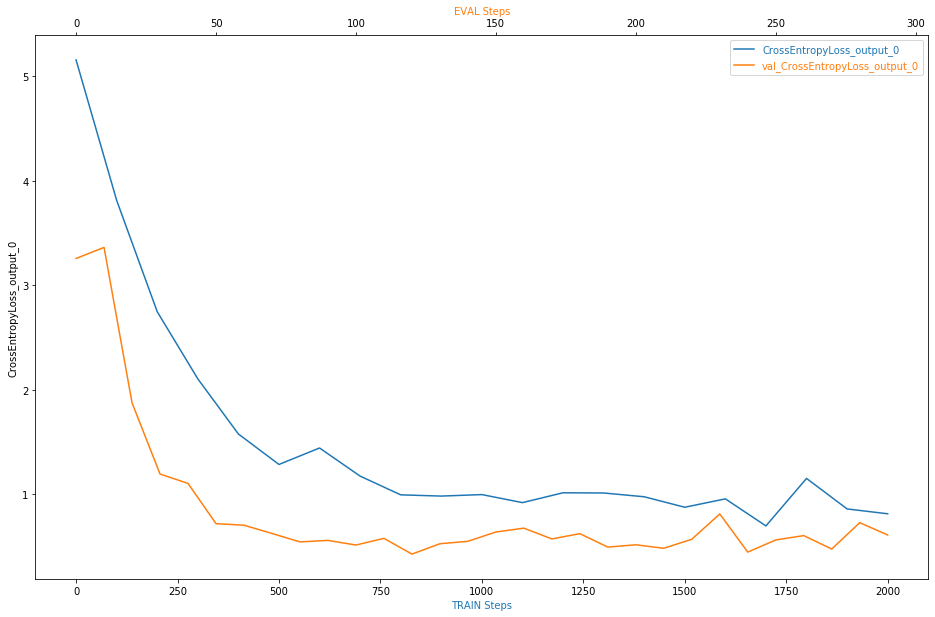

In [43]:
# TODO: Plot a debugging output.
plot_tensor(trial, tensor_name)


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [44]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-267669939222/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-10-01-41-18-450/profiler-output


Profiler data from system is available


In [45]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)


[2021-12-10 02:37:37.492 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO metrics_reader_base.py:134] Getting 51 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


In [46]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")


You will find the profiler report in s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-10-01-41-18-450/rule-output


In [47]:
# ! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-10-01-41-18-450/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-10-01-41-18-450/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-10-01-41-18-450/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-10-01-41-18-450/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-26766993922

In [48]:
# TODO: Display the profiler output
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
print(profiler_report_name)

ProfilerReport


In [50]:
! tar czf ProfilerReport.tgz ProfilerReport/

In [ ]:
# import IPython

# IPython.display.HTML(filename=profiler_report_name +
#      "/profiler-output/profiler-report.html")


## Model Deploying

In [12]:
# TODO: Deploy your model to an endpoint
# TODO: Add your deployment configuration like instance type and number of instances
# training_job_name = estimator.latest_training_job.name
# print(f'training_job_name = {training_job_name}')

# from time import time
# since = time()
# predictor = estimator.deploy(initial_instance_count=1, 
#                              instance_type="ml.r5.large") 
# print(f'Time deploy: {time() - since: .01f}' s)
# endpoint_name = predictor.endpoint_name
# print(f'endpoint_name = {endpoint_name}')

# endpoint_name = pytorch-training-2021-12-12-21-20-31-923
# No result.

training_job_name = pytorch-training-2021-12-12-20-45-58-832
-------!Time deploy: 218.24198508262634
pytorch-training-2021-12-12-21-20-31-923


In [7]:
#########
# create endpoint
#######
training_job_name = "pytorch-training-2021-12-12-20-45-58-832"
# model_name = 's3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-12-20-45-58-832/output/model.tar.gz'

bucket = sagemaker_session.default_bucket()

model_name = 's3://{}/{}/output/model.tar.gz'.format(bucket,training_job_name)
print(model_name)
# print(f'model_name = {}'.format(model_name))
# s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-12-20-45-58-832/output/model.tar.gz

s3://sagemaker-us-east-1-267669939222/pytorch-training-2021-12-12-20-45-58-832/output/model.tar.gz


In [8]:
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

model_name = 's3://{}/{}/output/model.tar.gz'.format(bucket,training_job_name)

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

fn_model = PyTorchModel(model_data=model_name, 
                         role=role,
                         entry_point='inference.py',
                         py_version='py38',
                         framework_version='1.9',
                         predictor_cls=ImagePredictor
                        )

In [30]:
# fn_model.deploy()
#### Important
from time import time
since = time()
fn_predictor = fn_model.deploy(
#     data_capture_config = data_capture_config,
    initial_instance_count=1, 
    instance_type="ml.m5.large"
    ) 
print(f'Time deploy: {time() - since} s')

endpoint_name = fn_predictor.endpoint_name
print(endpoint_name)
# pytorch-inference-2021-12-13-20-31-24-675

-------!Time deploy: 218.8348925113678 s
pytorch-inference-2021-12-13-20-31-24-675


In [9]:
# fn_model.deploy()
#### Important
from time import time
since = time()
fn_predictor = fn_model.deploy(
#     data_capture_config = data_capture_config,
    initial_instance_count=1, 
    instance_type="ml.m5.large"
    ) 
print(f'Time deploy: {time() - since} s')

endpoint_name = fn_predictor.endpoint_name
print(endpoint_name)
# pytorch-inference-2021-12-13-20-31-24-675

-------!Time deploy: 219.01304864883423 s
pytorch-inference-2021-12-15-02-04-11-482


In [10]:
print(f'endpoint_name = {endpoint_name}')

endpoint_name = pytorch-inference-2021-12-15-02-04-11-482


In [32]:
###
# Prepare data for predicting
####
# Create list of test files ldict 
import os
import random

datapath = 'dogImages'

def get_test_files(datapath):
    # dic = {'files': [], 'classes': [] }
    ldict = []
    for dirname, _, filenames in os.walk(datapath + '/test'):
        for filename in filenames:
            file_name = os.path.join(dirname, filename)
            # ldic.append({'file': file_name})
            class_id = int(file_name.split('/')[2].split('.')[0]) - 1
            ldict.append({'class': class_id, 'file': file_name})

    return ldict 

ldict = get_test_files(datapath)
print(len(ldict))
# row = random.randint(0, len(ldic))-1
# ldic[row]

836


In [33]:
#  Get one random filename form test file list for predicting
def get_filename_classid(ldict):
    ldict = ldict 
    row = random.randint(0, len(ldict))-1
    # ldic[row].values()
    class_id, file_name = ldict[row].values()
    return class_id, file_name

ldict = get_test_files(datapath)
# get_filename_classid(ldic)
classid, filename = get_filename_classid(ldict)
print(f'{filename}, {classid}')


dogImages/test/091.Japanese_chin/Japanese_chin_06168.jpg, 90


In [34]:
from sagemaker.serializers import IdentitySerializer
# import base64
# payload = pay
with open(filename, "rb") as f:
    payload = f.read()
#     payload = bytearray(payload)
    
since = time()
fn_predictor.serializer = IdentitySerializer("image/jpeg")
inference = fn_predictor.predict(payload)
print(f'Time Prediction: {time() - since} s')


Time Prediction: 0.3995931148529053 s


In [39]:
print(len(inference[0]))
prediction = np.argmax(inference)
if prediction == classid:
    print('Prediction is correct')
else:
    print('Prediction is not correct')
print(prediction, filename, classid)


133
Prediction is correct
90 dogImages/test/091.Japanese_chin/Japanese_chin_06168.jpg 90


In [40]:
since = time()
infers = []
files = []
classes = []
preds = []
count = 0
nums = 30
for k in range(30):
    classid, filename = get_filename_classid(ldict)
    classes.append(classid)
    files.append(filename)
    with open(filename, "rb") as f:
        payload = f.read()
    
    inference = fn_predictor.predict(payload)
    infers.append(inference[0])
    prediction = np.argmax(inference[0])
    preds.append(prediction)
    if prediction == classid:
        count = count + 1

print(f'Time {nums} Prediction: {time() - since} s')

Time 30 Prediction: 4.960650682449341 s


In [41]:
accu = count / nums
print(f'Accuracy of 30 predictions: {accu: .04f} = {accu*100: .0f}%')

Accuracy of 30 predictions:  0.5667 =  57%


In [54]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
# fn_predictor.delete_endpoint()
### Finish

In [42]:
since = time()
infers = []
files = []
classes = []
preds = []
count = 0
nums = 30
for k in range(30):
    classid, filename = get_filename_classid(ldict)
    classes.append(classid)
    files.append(filename)
    with open(filename, "rb") as f:
        payload = f.read()
    
    inference = fn_predictor.predict(payload)
    infers.append(inference[0])
    prediction = np.argmax(inference[0])
    preds.append(prediction)
    if prediction == classid:
        count = count + 1

print(f'Time {nums} Prediction: {time() - since} s')

accu = count / nums
print(f'Accuracy of 30 predictions: {accu: .04f} = {accu*100: .0f}%')


Time 30 Prediction: 4.911519765853882 s
Accuracy of 30 predictions:  0.7667 =  77%


In [11]:
### NEW PROCESS
print(f'endpoint_name = {endpoint_name}')

endpoint_name = pytorch-inference-2021-12-15-02-04-11-482


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import random
from time import time

mydata = pd.read_csv('stats.csv')
print(mydata.describe(),'\n\n',mydata.head(),'\n')
mydata[['test_props', 'train_props']].corr()

              id    test_num   train_num  test_props  train_props
count  133.00000  133.000000  133.000000  133.000000   133.000000
mean    66.00000    6.285714   50.225564    0.007519     0.007519
std     38.53786    1.712571   11.863885    0.002049     0.001776
min      0.00000    3.000000   26.000000    0.003589     0.003892
25%     33.00000    5.000000   42.000000    0.005981     0.006287
50%     66.00000    6.000000   50.000000    0.007177     0.007485
75%     99.00000    8.000000   61.000000    0.009569     0.009132
max    132.00000   10.000000   77.000000    0.011962     0.011527 

    id  test_num  train_num  test_props  train_props
0   0         8         64    0.009569     0.009581
1   1         8         58    0.009569     0.008683
2   2         6         52    0.007177     0.007784
3   3         8         63    0.009569     0.009431
4   4        10         77    0.011962     0.011527 



,test_props,train_props
test_props,1.000000,0.979301
train_props,0.979301,1.000000


### From correlation efficient, we have conclusion: True linear correlation of the classees of test and train. Good data

In [13]:
import random
from time import time
test_files = pd.read_csv('test_files.csv')
list_tfiles = test_files.values

since = time()
infers = []
files = []
classes = []
preds = []
count = 0
success =[]
succ_classes = {}
nums = len(list_tfiles)

for item in list_tfiles:
    id, filename = item

    classes.append(id)
    files.append(filename)
#     prediction = random.choice([id, id, id, 150, 150])
    with open(filename, "rb") as f:
        payload = f.read()
    
    inference = fn_predictor.predict(payload)
    infers.append(inference[0])
    prediction = np.argmax(inference[0])

    preds.append(prediction)
    if prediction == id:
        success.append(1)
        count = count + 1
        if id not in succ_classes.keys():
            succ_classes[id] = 1
        else:
            succ_classes[id] += 1
    else:
        success.append(0)
        
print(f'Time {nums} Prediction: {time() - since: .01f} s')
accu = count / nums
print(f'Accuracy of all test directory predictions: {accu: .04f} = {accu*100: .0f}%')


Time 836 Prediction:  109.9 s
Accuracy of all test directory predictions:  0.5885 =  59%


Text(0, 0.5, 'Successful proportion')

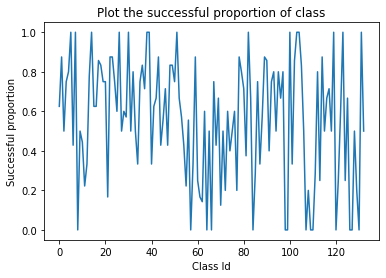

In [14]:
# Add 0 to classid has 0 success
# num_tests = len(list_tfiles)
num_tests = mydata['test_num'].sum()
id = []
vals = []
for k in range(133):
    id.append(k)
    if k in succ_classes.keys():        
        vals.append(succ_classes[k])
    else:
        vals.append(0)

assert (len(vals) == 133)

df = pd.DataFrame(id, columns=['id'])
df['success'] = vals
df['succ_prop'] = np.array(vals) / np.array(mydata['test_num'])
# print(df.describe())
df.to_csv('succ_classes.csv', index=False)
mydata['preds'] = df['succ_prop']
# df['succ_prop'].sum()
# plt.title = 'Plot the successful proportion of class'
ax = df['succ_prop'].plot(title='Plot the successful proportion of class')
ax.set_xlabel("Class Id")
ax.set_ylabel("Successful proportion")

In [15]:
mydata[['test_props', 'preds']].corr()

,test_props,preds
test_props,1.000000,0.345541
preds,0.345541,1.000000


Text(6.799999999999997, 0.5, 'Class Successful Prediction')

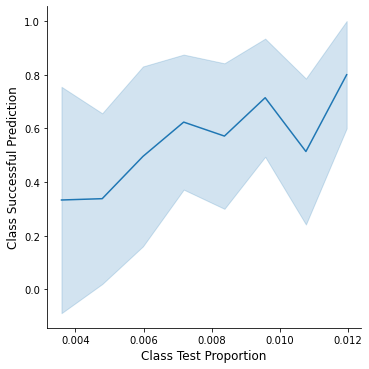

In [9]:
# Plot the relative plot between predictions of each class to the proportion of test file in class.
mydata.head()
mydata['preds'] = df['succ_prop']

# Increase the size of Seaborn plot
sns.relplot(x = 'test_props', y = 'preds', kind="line", ci = 'sd',  data=mydata)
plt.xlabel("Class Test Proportion", size=12)
plt.ylabel("Class Successful Prediction", size=12)


#### The correlation efficience between test_prop and predictions is small, but the plot shows clearly the relation, it means that if the numbers of test file in class is small than other, the successful prediction is smaller.

In [18]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
fn_predictor.delete_endpoint()
### Finish